In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws

In [9]:
spark = SparkSession.builder.appName("Beer analysis").getOrCreate()

In [11]:
df = spark.read.csv("../data/70_percent_train_data.csv",
                    header=True,
                    inferSchema=True)

In [12]:
from pyspark.sql.functions import col, date_format, to_timestamp

df = df.withColumn("Brew_Date", to_timestamp(col("Brew_Date"), "yyyy-MM-dd HH:mm:ss"))

# Extract month, day, year, and time from Brew_Date
df = df.withColumn("Month", date_format(col("Brew_Date"), "MM")) \
       .withColumn("Day", date_format(col("Brew_Date"), "dd")) \
       .withColumn("Year", date_format(col("Brew_Date"), "yyyy")) \
       .withColumn("Time", date_format(col("Brew_Date"), "HH:mm:ss"))

# Display the DataFrame with the new columns
df.select("Brew_Date", "Month", "Day", "Year", "Time").show()

+-------------------+-----+---+----+--------+
|          Brew_Date|Month|Day|Year|    Time|
+-------------------+-----+---+----+--------+
|2020-01-01 00:00:19|   01| 01|2020|00:00:19|
|2020-01-01 00:00:31|   01| 01|2020|00:00:31|
|2020-01-01 00:00:40|   01| 01|2020|00:00:40|
|2020-01-01 00:01:37|   01| 01|2020|00:01:37|
|2020-01-01 00:01:43|   01| 01|2020|00:01:43|
|2020-01-01 00:01:48|   01| 01|2020|00:01:48|
|2020-01-01 00:01:49|   01| 01|2020|00:01:49|
|2020-01-01 00:01:51|   01| 01|2020|00:01:51|
|2020-01-01 00:02:16|   01| 01|2020|00:02:16|
|2020-01-01 00:02:32|   01| 01|2020|00:02:32|
|2020-01-01 00:02:36|   01| 01|2020|00:02:36|
|2020-01-01 00:02:55|   01| 01|2020|00:02:55|
|2020-01-01 00:03:04|   01| 01|2020|00:03:04|
|2020-01-01 00:03:09|   01| 01|2020|00:03:09|
|2020-01-01 00:03:12|   01| 01|2020|00:03:12|
|2020-01-01 00:03:17|   01| 01|2020|00:03:17|
|2020-01-01 00:03:22|   01| 01|2020|00:03:22|
|2020-01-01 00:03:26|   01| 01|2020|00:03:26|
|2020-01-01 00:03:31|   01| 01|202

In [13]:
df.show()

+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+---+----+--------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Month|Day|Year|    Time|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+----

In [14]:
df.printSchema()

root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Year: string 

In [15]:
df.describe().show()

+-------+-----------------+----------+-------+---------------+------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+------------------+-----------------+------------------+--------+
|summary|         Batch_ID|Beer_Style|    SKU|       Location| Fermentation_Time|       Temperature|           pH_Level|             Gravity|    Alcohol_Content|        Bitterness|             Color|Ingredient_Ratio|   Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|             Month|              Day|              Year|    Time|
+-------+-----------------+----------+-------+---------------+------------------+------------------+-------------------+------------

In [16]:
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+--------+---------+----------+---+--------+-----------------+-----------+--------+-------+---------------+----------+-----+----------------+---------------+-----------+-------------+--------------------+-------------------+------------------------+----------------------------+-----+---+----+----+
|Batch_ID|Brew_Date|Beer_Style|SKU|Location|Fermentation_Time|Temperature|pH_Level|Gravity|Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|Total_Sales|Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Month|Day|Year|Time|
+--------+---------+----------+---+--------+-----------------+-----------+--------+-------+---------------+----------+-----+----------------+---------------+-----------+-------------+--------------------+-------------------+------------------------+----------------------------+-----+---+----+----+
|       0|        0|         0|  0|       0|                0|          0|       0|      0|            

In [17]:
num_rows = df.count()
print(num_rows)

7000000


                              Batch_ID  Fermentation_Time  Temperature  \
Batch_ID                      1.000000           0.000064     0.000068   
Fermentation_Time             0.000064           1.000000     0.000202   
Temperature                   0.000068           0.000202     1.000000   
pH_Level                      0.000230          -0.000200    -0.000556   
Gravity                      -0.000134           0.000449     0.000356   
Alcohol_Content               0.000176          -0.000030     0.000176   
Bitterness                    0.000111          -0.000227     0.000013   
Color                         0.000533          -0.000469     0.000624   
Volume_Produced              -0.000077          -0.000219     0.000305   
Total_Sales                   0.000053           0.000321     0.000171   
Quality_Score                 0.000552          -0.000037     0.000512   
Brewhouse_Efficiency          0.000042          -0.000133    -0.000909   
Loss_During_Brewing          -0.000297

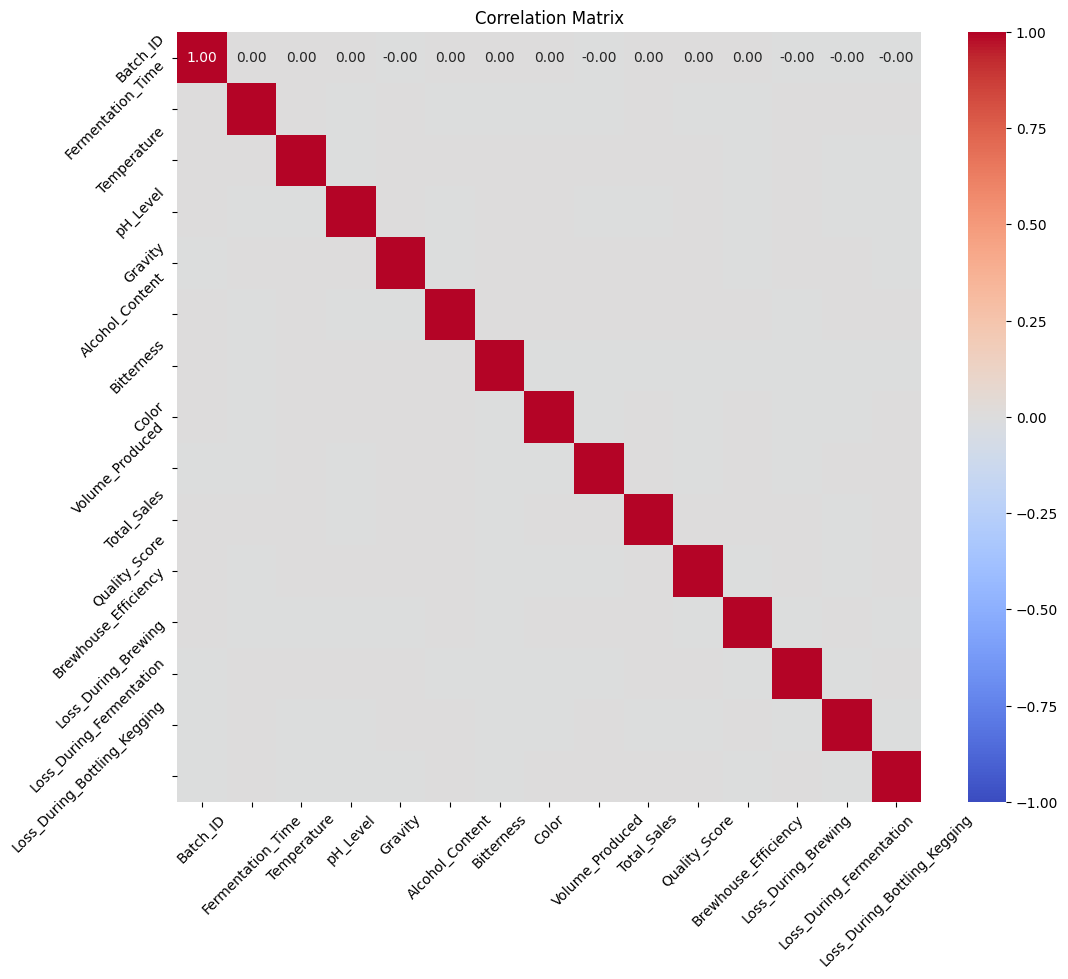

In [18]:
# Select only numerical columns
numeric_cols = [col for col in df.columns if dict(df.dtypes)[col] in ["int", "double"]]

# Assemble the numerical columns into a feature vector
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]
correlation_matrix = correlation_matrix.toArray()

# Convert the correlation matrix to a Pandas DataFrame for visualization
correlation_df = pd.DataFrame(correlation_matrix, index=numeric_cols, columns=numeric_cols)

# Display the correlation matrix
print(correlation_df)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [19]:
# Melt the correlation DataFrame to get variable pairs and their correlations
correlation_melted = correlation_df.reset_index().melt(id_vars='index')
correlation_melted.columns = ['Variable1', 'Variable2', 'Correlation']

# Remove self-correlations and duplicate pairs
correlation_melted = correlation_melted[correlation_melted['Variable1'] != correlation_melted['Variable2']]
correlation_melted['abs_correlation'] = correlation_melted['Correlation'].abs()

# Sort by the absolute value of the correlation and get the top 3
top_correlations = correlation_melted.sort_values(by='abs_correlation', ascending=False).drop_duplicates(subset=['abs_correlation']).head(5)

print("Top 3 Correlations:")
print(top_correlations[['Variable1', 'Variable2', 'Correlation']])

Top 3 Correlations:
                        Variable1             Variable2  Correlation
156                    Bitterness         Quality_Score    -0.001083
123                      pH_Level       Volume_Produced    -0.001072
139                       Gravity           Total_Sales     0.000973
167                   Temperature  Brewhouse_Efficiency    -0.000909
164  Loss_During_Bottling_Kegging         Quality_Score     0.000798


In [20]:

# Create a unique identifier for each row by concatenating all column values
unique_identifier = concat_ws("_", *df.columns)

# Add this unique identifier as a new column
df_with_id = df.withColumn("unique_id", unique_identifier)

# Group by the unique identifier and count the occurrences
duplicate_counts = df_with_id.groupBy("unique_id").count().filter(col("count") > 1)

# Count the number of duplicate rows
duplicate_count = duplicate_counts.count()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [21]:
from pyspark.sql.functions import avg

# Calculate average alcohol content and bitterness by beer style
avg_alcohol_bitterness = df.groupBy("Beer_Style") \
    .agg(avg("Alcohol_Content").alias("Avg_Alcohol_Content"),
         avg("Bitterness").alias("Avg_Bitterness"))

avg_alcohol_bitterness.show()


+----------+-------------------+------------------+
|Beer_Style|Avg_Alcohol_Content|    Avg_Bitterness|
+----------+-------------------+------------------+
|    Porter|  5.249346408157071| 39.50792699151173|
|      Sour|  5.249153126229794| 39.49474096011366|
|     Lager|  5.249784868466294|39.489085474265394|
|Wheat Beer|  5.250387548915359| 39.49387047088917|
|   Pilsner|  5.249506763557662|39.497950756419534|
|       Ale|  5.249538666096094| 39.50217868904124|
|     Stout|  5.249933308740647| 39.49895418053473|
|       IPA|  5.249708373394683|  39.4835148509194|
+----------+-------------------+------------------+



In [22]:
# Calculate total sales by beer style
total_sales_by_style = df.groupBy("Beer_Style") \
    .sum("Total_Sales") \
    .withColumnRenamed("sum(Total_Sales)", "Total_Sales")

total_sales_by_style.show()


+----------+-------------------+
|Beer_Style|        Total_Sales|
+----------+-------------------+
|    Porter|  9.1934032670442E9|
|      Sour|9.178466054585722E9|
|     Lager|9.187083801668077E9|
|Wheat Beer|9.181434698153645E9|
|   Pilsner| 9.18736300737978E9|
|       Ale|9.208493859526539E9|
|     Stout|9.175348379831303E9|
|       IPA|9.181481842569775E9|
+----------+-------------------+



In [23]:
# Calculate average temperature and pH level by beer style
avg_temp_ph = df.groupBy("Beer_Style") \
    .agg(avg("Temperature").alias("Avg_Temperature"),
         avg("pH_Level").alias("Avg_pH_Level"))

avg_temp_ph.show()


+----------+------------------+------------------+
|Beer_Style|   Avg_Temperature|      Avg_pH_Level|
+----------+------------------+------------------+
|    Porter|19.998768249667393| 4.999873611883576|
|      Sour|20.003259926214668|4.9997397278157285|
|     Lager|20.002217883583494| 5.000311129832932|
|Wheat Beer|20.002224044331104| 4.999915308606895|
|   Pilsner|19.998356985760527|4.9997201919364045|
|       Ale| 19.99777911204929| 5.000169380429744|
|     Stout|20.002938536922898|4.9999348420810135|
|       IPA| 19.99504533425316|4.9998242336909025|
+----------+------------------+------------------+



In [24]:
df.show(20)

+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+---+----+--------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Month|Day|Year|    Time|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+----

In [25]:
df.printSchema()

root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Year: string 

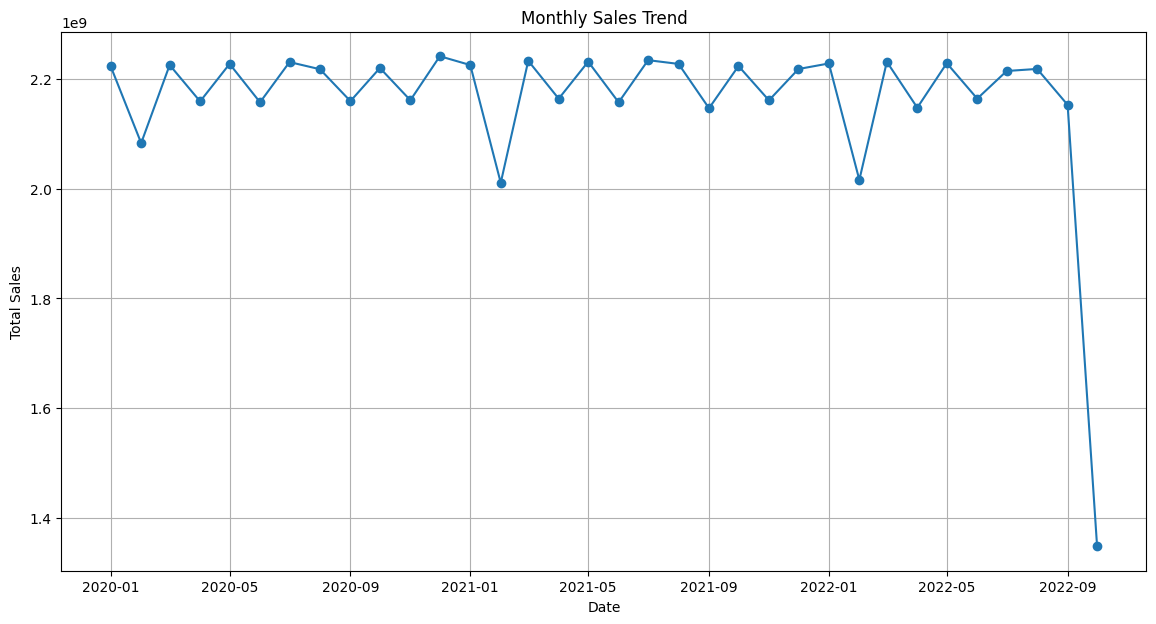

In [26]:
#Monthly sales

# Monthly Sales Trend
monthly_sales = df.groupBy("Year", "Month") \
    .agg(sum("Total_Sales").alias("Total_Sales")) \
    .orderBy("Year", "Month")

# Convert to Pandas DataFrame for visualization
monthly_sales_pd = monthly_sales.toPandas()

# Plot Monthly Sales Trend
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(monthly_sales_pd['Year'].astype(str) + '-' + monthly_sales_pd['Month'].astype(str)),
         monthly_sales_pd['Total_Sales'], marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

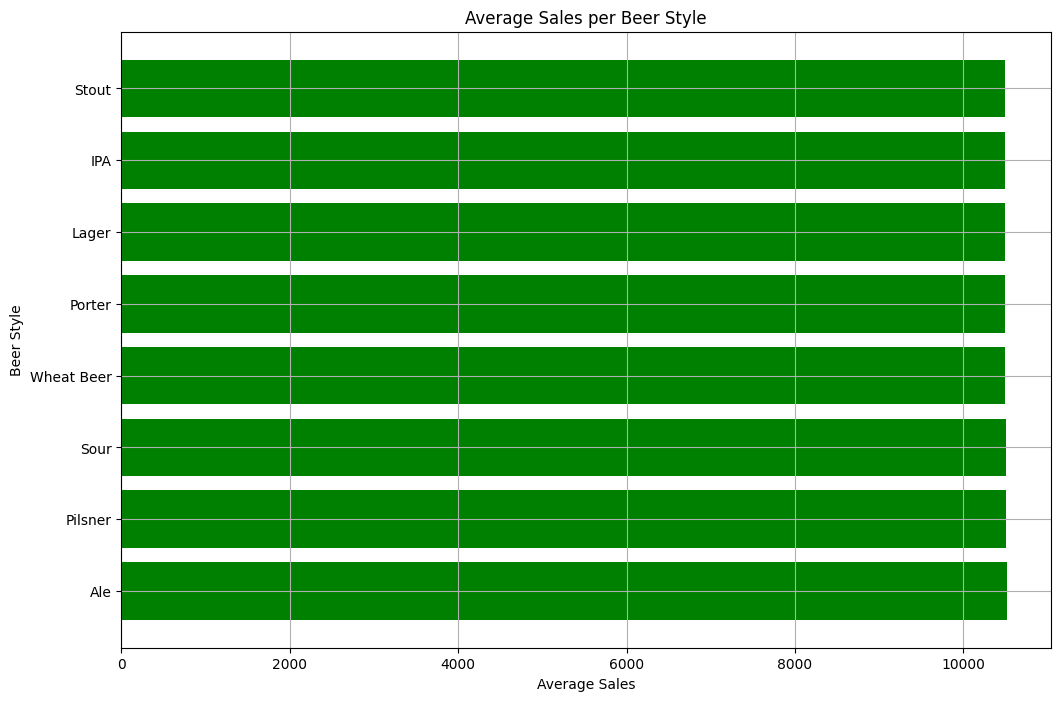

In [27]:
# Average Sales per Beer Style
avg_sales_per_style = df.groupBy("Beer_Style") \
    .agg(avg("Total_Sales").alias("Avg_Sales")) \
    .orderBy("Avg_Sales", ascending=False)

# Convert to Pandas DataFrame for visualization
avg_sales_per_style_pd = avg_sales_per_style.toPandas()

# Plot Average Sales per Beer Style
plt.figure(figsize=(12, 8))
plt.barh(avg_sales_per_style_pd['Beer_Style'], avg_sales_per_style_pd['Avg_Sales'], color='green')
plt.title('Average Sales per Beer Style')
plt.xlabel('Average Sales')
plt.ylabel('Beer Style')
plt.grid(True)
plt.show()


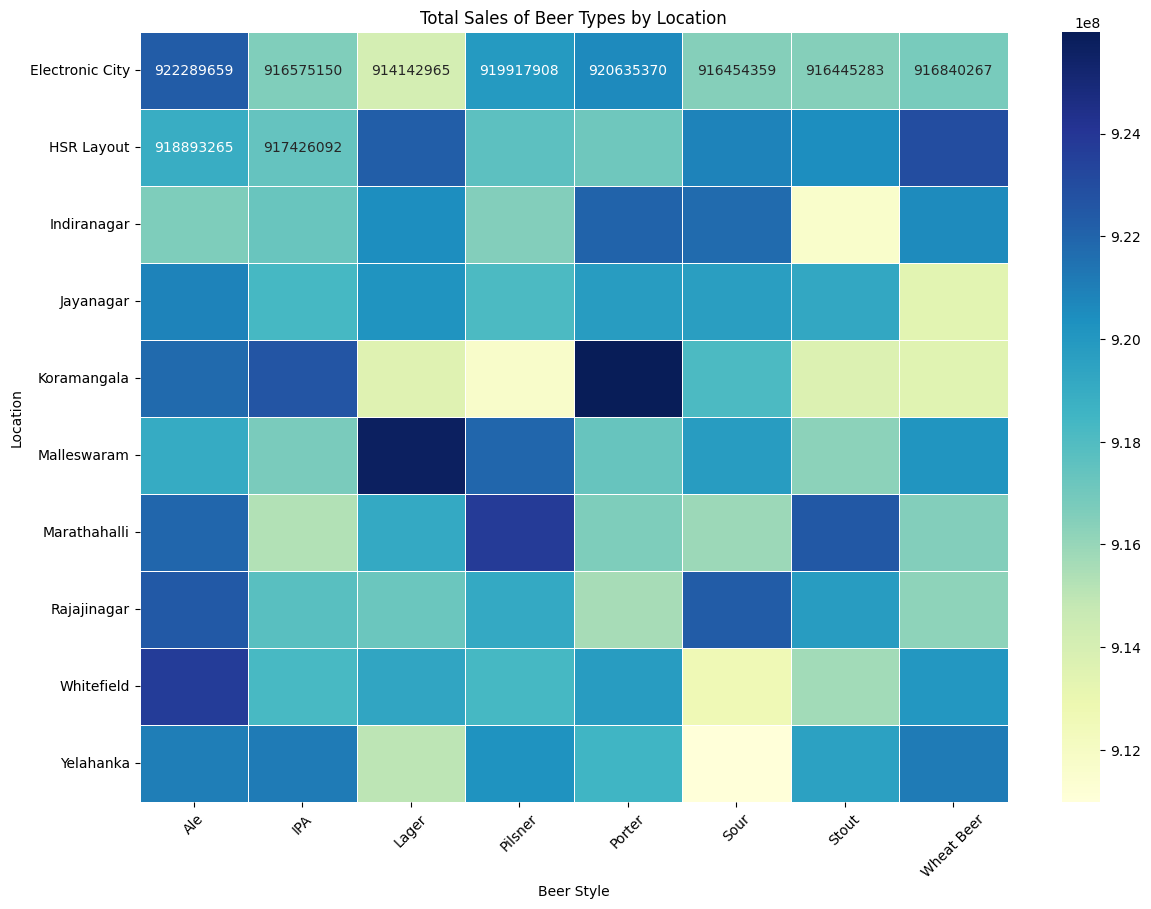

In [28]:
# Aggregate data by Beer_Style and Location, summing the Total_Sales
sales_by_type_location = df.groupBy("Beer_Style", "Location") \
    .agg(sum("Total_Sales").alias("Total_Sales")) \
    .orderBy("Beer_Style", "Location")

# Convert to Pandas DataFrame for visualization
sales_by_type_location_pd = sales_by_type_location.toPandas()

# Create a pivot table for better visualization
pivot_table = sales_by_type_location_pd.pivot(index='Location', columns='Beer_Style', values='Total_Sales')

# Plotting the data
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Sales of Beer Types by Location')
plt.xlabel('Beer Style')
plt.ylabel('Location')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

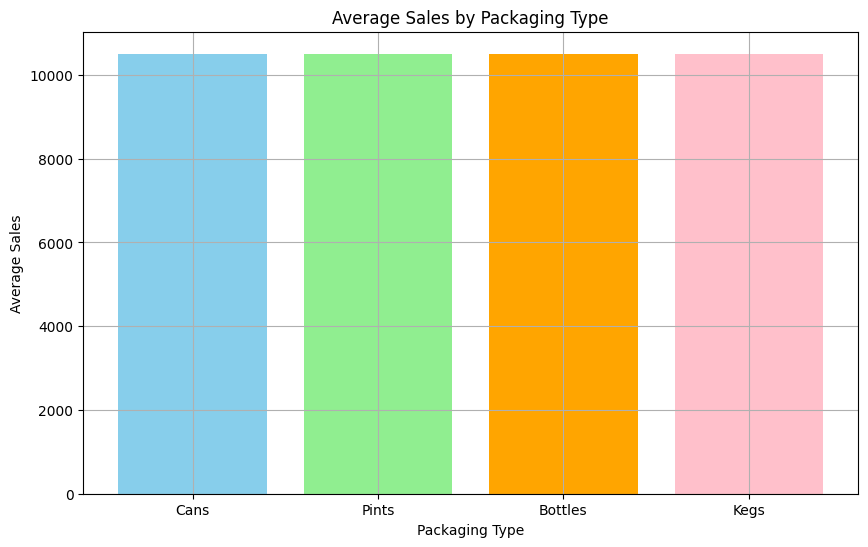

In [29]:
# Aggregate data by SKU, calculating the average Total_Sales
avg_sales_by_sku = df.groupBy("SKU") \
    .agg(avg("Total_Sales").alias("Avg_Sales")) \
    .orderBy("Avg_Sales", ascending=False)

# Convert to Pandas DataFrame for visualization
avg_sales_by_sku_pd = avg_sales_by_sku.toPandas()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(avg_sales_by_sku_pd['SKU'], avg_sales_by_sku_pd['Avg_Sales'], color=['skyblue', 'lightgreen', 'orange', 'pink'])
plt.title('Average Sales by Packaging Type')
plt.xlabel('Packaging Type')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

In [30]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=["Fermentation_Time", "Temperature", "pH_Level", "Gravity", "Alcohol_Content", "Bitterness", "Color", "Volume_Produced", "Quality_Score", "Brewhouse_Efficiency", "Loss_During_Brewing", "Loss_During_Fermentation", "Loss_During_Bottling_Kegging"],
                            outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="Total_Sales")
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="Total_Sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 5490.815244842418


In [31]:
from pyspark.ml.regression import RandomForestRegressor
assembler = VectorAssembler(
    inputCols=["Fermentation_Time", "Temperature", "pH_Level", "Gravity", "Alcohol_Content", 
               "Bitterness", "Color", "Volume_Produced", "Quality_Score", 
               "Brewhouse_Efficiency", "Loss_During_Brewing", 
               "Loss_During_Fermentation", "Loss_During_Bottling_Kegging"],
    outputCol="features")


train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestRegressor(featuresCol="features", labelCol="Total_Sales")
pipeline = Pipeline(stages=[assembler, rf])

model = pipeline.fit(train_data)
predictions = model.transform(test_data)

predictions.select("prediction", "Total_Sales", "features").show(5)

evaluator = RegressionEvaluator(labelCol="Total_Sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|       Total_Sales|            features|
+------------------+------------------+--------------------+
|10502.914498670536| 5608.093834068051|[12.0,24.58145716...|
|10500.812931969329|  6436.80447593548|[17.0,21.69684900...|
|10510.509913810121| 13717.51932768758|[11.0,24.58601289...|
|10475.739635118367|14839.352279710096|[13.0,21.90986466...|
|10520.813724186195| 7820.054670655571|[17.0,24.87397672...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 5490.83
